### Measure variance in GP models with different samples

Use randomly selected training sample to measure difference in GP surface predictions

In [1]:
from caat import SNCollection, GP3D, Kernel
from sklearn.gaussian_process.kernels import RBF
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import logging

logger = logging.getLogger()
logger.setLevel(logging.ERROR)

Configuration file not found:

    /Users/craigpellegrino/.dustmapsrc

To create a new configuration file in the default location, run the following python code:

    from dustmaps.config import config
    config.reset()

Note that this will delete your configuration! For example, if you have specified a data directory, then dustmaps will forget about its location.


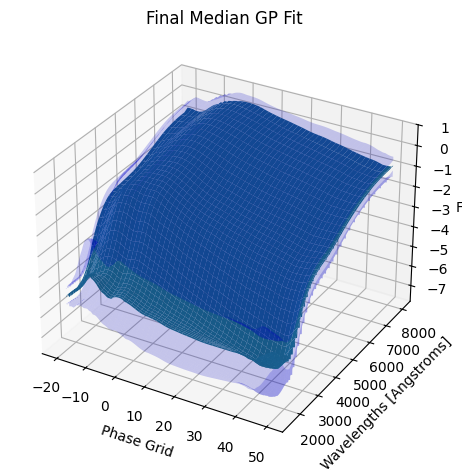

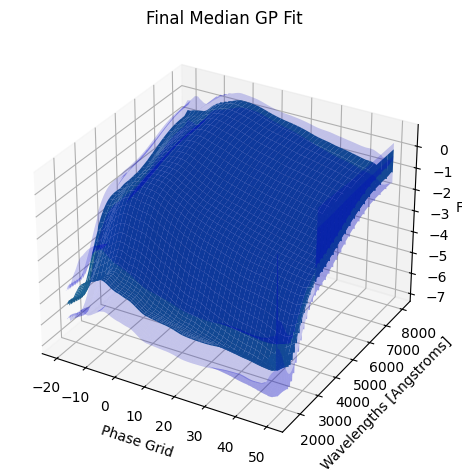

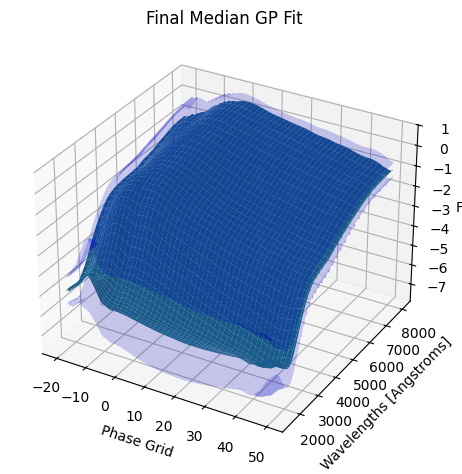

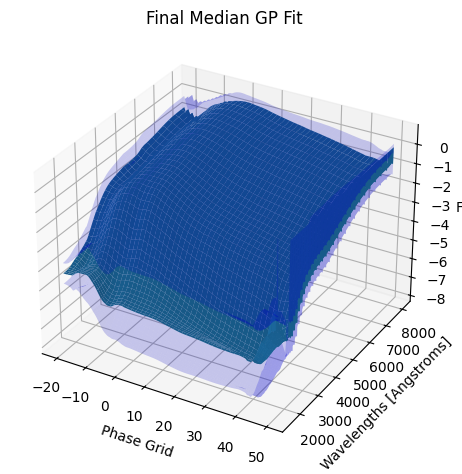

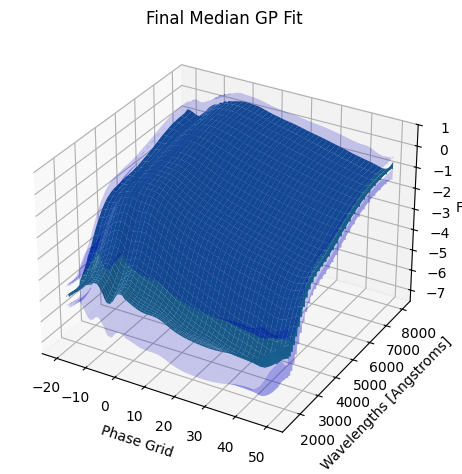

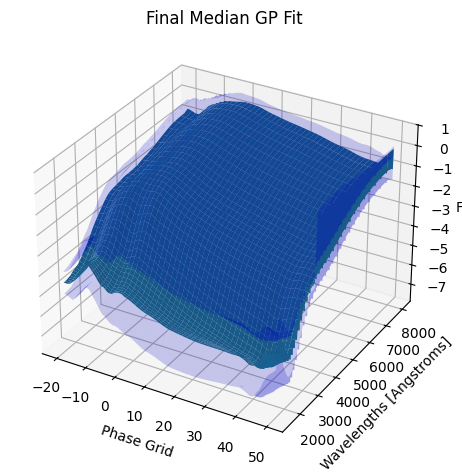

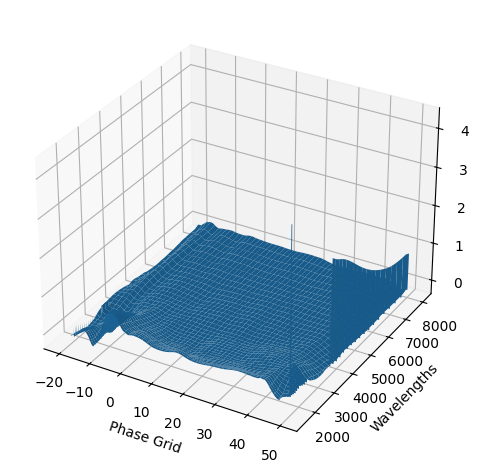

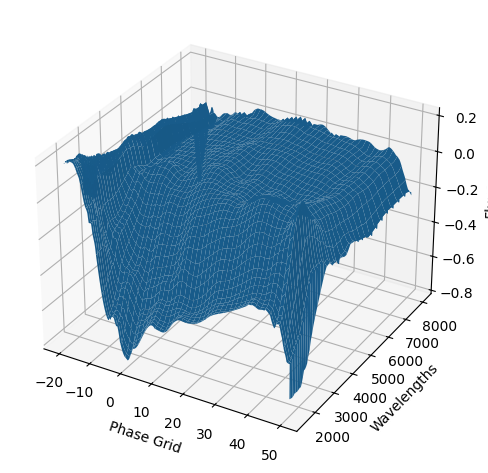

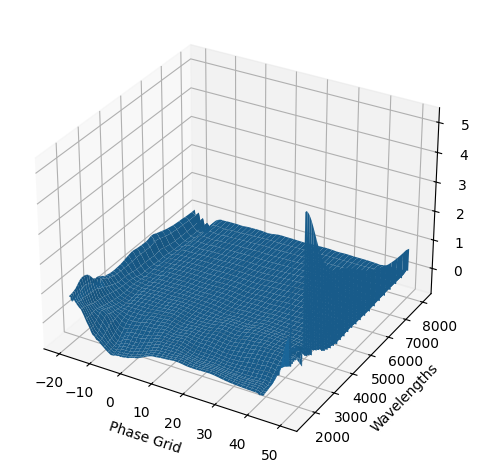

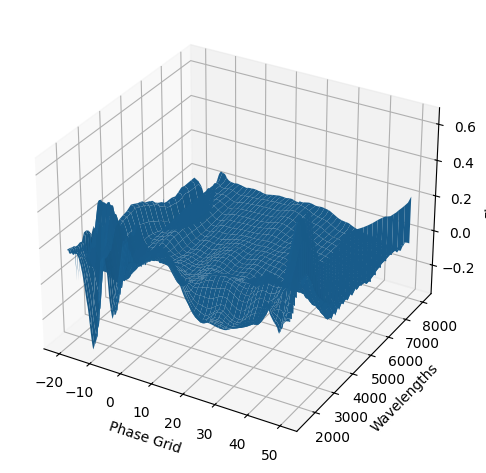

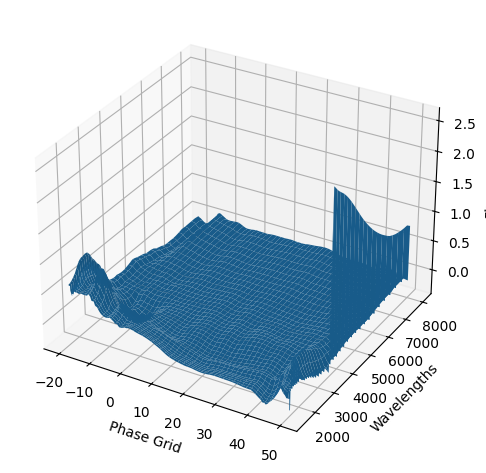

In [3]:
filts = ['UVW2', 'UVM2', 'UVW1', 'U', 'B', 'g', 'c', 'V', 'r', 'o', 'i']
phasemin = -20
phasemax = 50
log_transform = 22
mangle_sed = True
use_full_sed = True
plot = False

surfaces = []
for i in range(6):
    sn_type = SNCollection(sntype="SESNe", snsubtype="SNIb")
    sn_to_normalize = SNCollection(sntype="SESNe")
    kernel = Kernel(RBF([np.log(10.0), np.log10(500.0)], (0.1, 4.0)))
    if i > 0:
        sne, _ = train_test_split(sn_type.sne, train_size=0.8)
        sn_type = SNCollection(SNe=sne)
    gp = GP3D(
        sn_type, 
        kernel, 
        filts,
        phasemin, 
        phasemax,
        set_to_normalize=sn_to_normalize,
        log_transform=log_transform,
        mangle_sed=mangle_sed,
    )

    kernel_params = gp.optimize_hyperparams(subtract_polynomial=True)

    optimized_kernel_hyperparams = np.asarray([np.median([k[i] for k in kernel_params]) for i in range(len(kernel_params[0]))])

    snmodel = gp.predict(
        plot=plot,
        subtract_polynomial=True,
        fit_separately=True
    )

    surface = snmodel.surface.surface
    surfaces.append(surface)

original_surface = surfaces[0]
for surface in surfaces[1:]:
    diff = surface - original_surface
    x, y = np.meshgrid(snmodel.phase_grid, snmodel.wl_grid)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    ax.plot_surface(x, y, diff)
    ax.set_xlabel("Phase Grid")
    ax.set_ylabel("Wavelengths")
    ax.set_zlabel("Fluxes")
    plt.tight_layout()
    plt.show()